In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

## Plotting HPs

We'll want to make different figures for different kernel types, and dimensionality?

In [2]:
KERNEL_TYPE = "matern-5/2"
N_DIM = 4

In [3]:
DATA_DIR = Path().cwd().parent / "data"
assert DATA_DIR.exists(), f"{DATA_DIR} does not exist"

df = pd.read_json(DATA_DIR / "benchmark_df.json")

se_data = df[df['kernel_type'] == KERNEL_TYPE].copy()

print(f"Loaded {len(se_data)} runs with SE kernel")
print(f"Unique combinations: {se_data.groupby(['acq_func', 'len_scale', 'n_dim']).ngroups}")
se_data

Loaded 4800 runs with SE kernel
Unique combinations: 48


,acq_func,kernel_type,len_scale,n_dim,run_id,y_true_max,final_y_max,y_max_history,steps
4300,expected_improvement,matern-5/2,1,1,0,3.341194,3.341194,"[2.3970128631, 2.3970128631, 2.3970128631, 2.3...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
4301,expected_improvement,matern-5/2,1,1,1,2.527989,2.527989,"[1.9263359013, 1.9263359013, 2.5279892161, 2.5...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
4302,expected_improvement,matern-5/2,1,1,2,2.073370,2.073370,"[0.9612403126, 1.3815344462, 1.6597790586, 1.6...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
4303,expected_improvement,matern-5/2,1,1,3,2.160362,2.160362,"[0.9212976845, 0.9212976845, 0.9212976845, 0.9...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
4304,expected_improvement,matern-5/2,1,1,4,2.301217,2.301217,"[1.5983607149, 2.1886930142, 2.2704997594, 2.2...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
...,...,...,...,...,...,...,...,...,...
14395,random_search,matern-5/2,100,8,95,2.606816,2.078170,"[0.5870882424, 0.5870882424, 0.5870882424, 0.5...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
14396,random_search,matern-5/2,100,8,96,2.257901,2.257901,"[0.6598870636, 0.6598870636, 0.6598870636, 0.6...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
14397,random_search,matern-5/2,100,8,97,1.794926,1.788222,"[0.5641663655, 1.7882221344, 1.7882221344, 1.7...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
14398,random_search,matern-5/2,100,8,98,2.829480,2.106458,"[1.0943651807, 1.0943651807, 1.0943651807, 1.0...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."


In [4]:
se_data['regret'] = se_data.apply(lambda x: x['y_true_max'] - np.array(x['y_max_history']), axis=1)

regret_df = se_data[['acq_func', 'len_scale', 'n_dim', 'run_id', 'regret']].copy()
regret_df = regret_df.explode('regret').reset_index(drop=True) # Explode regret into new rows
regret_df['step'] = regret_df.groupby(['acq_func', 'len_scale', 'n_dim', 'run_id']).cumcount()

# Convert regret to numeric, from weird numpy types
regret_df['regret'] = pd.to_numeric(regret_df['regret'], errors='coerce')

regret_df = regret_df[regret_df["n_dim"] == N_DIM] # Filter for current dimension we care about

# Group by: acq_func (line), step (x).
# Aggregate: mean / std (y) and count for standard error calculation
regret_stats = regret_df.groupby(['acq_func', 'step'])['regret'].agg(['mean', 'std', 'count']).reset_index()

print(f"Created regret history for {len(regret_df)} data points")
print(f"Number of repetitions per setting: {regret_stats['count'].iloc[0]}")
regret_stats

Created regret history for 56400 data points
Number of repetitions per setting: 600


,acq_func,step,mean,std,count
0,expected_improvement,0,1.609274,0.808170,600
1,expected_improvement,1,1.401636,0.787223,600
2,expected_improvement,2,1.278016,0.772470,600
3,expected_improvement,3,1.166083,0.770777,600
4,expected_improvement,4,1.078723,0.762979,600
...,...,...,...,...,...
89,random_search,42,0.530485,0.461598,600
90,random_search,43,0.522305,0.457469,600
91,random_search,44,0.515767,0.455731,600
92,random_search,45,0.512994,0.454393,600


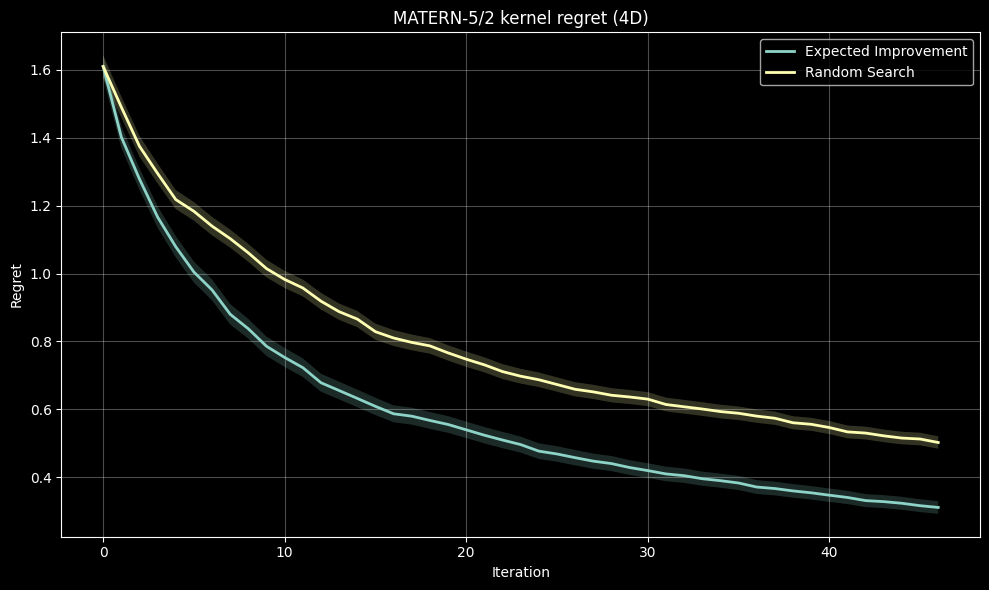

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

acq_funcs = regret_stats.acq_func.unique().tolist()
for method in acq_funcs:
    data = regret_stats[regret_stats['acq_func'] == method]
    ax.plot(data['step'], data['mean'], label=method.replace('_', ' ').title(), linewidth=2)
    standard_error = data['std'] / np.sqrt(data['count'])
    ax.fill_between(data['step'],
                    data['mean'] - standard_error,
                    data['mean'] + standard_error,
                    alpha=0.2)

ax.set_xlabel('Iteration')
ax.set_ylabel('Regret')
ax.set_title(f'{KERNEL_TYPE.upper()} kernel regret ({N_DIM}D)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()